In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os
import copy

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

jan1_2011 = '2011-01-01T00:00:00.000Z'
jan1_2011 = astropy.time.Time(jan1_2011).jd
print(jan1_2011)

2450083.5
2455562.5


In [3]:
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31,0]
months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']
# all years divisible by 4 during SOHO are leap years, including 2000

# load EIT

In [4]:
darkImgData =np.loadtxt("./EIT/darkImgFluxes_nobakeout.txt")
print(np.shape(darkImgData))

results = np.genfromtxt("./EIT/EITresults/EIT_LC_withflags.txt")
print(np.shape(results))

(2463, 3)
(91883, 7)


In [5]:
metadata = Table.read("./EIT/EITresults/EIT_headerMetadata.txt",format="ascii")
print(metadata.colnames)

['DATE-BEG', 'DATE-AVG', 'XPOSURE', 'CMDXPOS', 'SHUTCLS', 'FILTER', 'WAVELNTH', 'OBJECT', 'SCI_OBJ', 'OBS_PROG', 'CMP_NO', 'UCD', 'EXPMODE', 'LYNESYNC', 'ROUTPORT', 'NLEBPROC', 'LEBPROC1', 'LEBPROC2', 'LEBPROC3', 'WCSNAME', 'CTYPE1', 'CTYPE2', 'CUNIT1', 'CUNIT2', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CROTA', 'CFTEMP', 'CCDTEMP', 'SOLAR_B0', 'RSUN_ARC', 'RSUN_OBS', 'RSUN_REF', 'CAR_ROT', 'DSUN_OBS', 'SC_X0', 'SC_Y0', 'SC_ROLL', 'HAEX_OBS', 'HAEY_OBS', 'HAEZ_OBS']


In [6]:
medDist = np.median(results[:,1])*u.m
print(medDist)
print(medDist.to(u.AU))

AUinm = (u.AU.to(u.m))
print(AUinm)

148114320263.0 m
0.9900830778535941 AU
149597870700.0


In [7]:
# restrict to after commissioning was completed on Apr 16, 1996
postCommissioningMask = (results[:,0] >= 2450190.)
results = results[postCommissioningMask]
metadata = metadata[postCommissioningMask]

ts = results[:,0]                               # average date of observation
dists = results[:,1]                            # heliocentric distance in meters
ws = results[:,2].astype(float)                 # wavelength of observation
fs = results[:,3] * (dists/AUinm)               # normalize flux to heliocentric distance of 1AU
us = results[:,4] * (dists/AUinm)               # normalize flux uncertainty to heliocentric distance of 1AU
ps = results[:,5]                               # pinhole flag (==1 if Yes; can only ==1 if the Al_+1 filter was not used)
ces = results[:,6]                              # cameraError flag (==1 if Yes; still not clear exactly what this means)

m171 = (ws == 171.) 
m195 = (ws == 195.) 
m284 = (ws == 284.) 
m304 = (ws == 304.) 
wmasks = [m304,m284,m195,m171]

noPinholes = (ps == 0)
noCameraErrors = (ces == 0)


In [8]:
bakeoutDates = Table.read("./EIT/EITbakeoutDates.txt", format="ascii.basic")
bakeoutDates['jd'] = 0.

for i in range(len(bakeoutDates)):
    date = str(bakeoutDates['date_beg'][i])
    time = str(bakeoutDates['time_beg'][i]).zfill(5)

    y = int(date.split("/")[0])
    m = int(date.split("/")[1])
    d = int(date.split("/")[2])

    h = int(time.split(":")[0])
    min = int(time.split(":")[1])
    
    bakeoutDates[i]['jd'] = np.round(astropy.time.Time({'year':y, 'month':m, 'day':d, 'hour':h, 'minute':min}).jd,3)
    

heaterOnMask = (bakeoutDates['status'] == 'heaterOn')
heaterOffMask = (bakeoutDates['status'] == 'heaterOff')

heaterOn = bakeoutDates[heaterOnMask]
heaterOff = bakeoutDates[heaterOffMask]
print(heaterOn)
print(heaterOff)

 status   date_beg  time_beg dur[h]      jd    
-------- ---------- -------- ------ -----------
heaterOn 1996/05/23    19:21   45.0 2450227.306
heaterOn 1996/06/23    19:10   24.0 2450258.299
heaterOn 1996/07/23    15:48    2.5 2450288.158
heaterOn 1996/08/05    18:50   15.0 2450301.285
heaterOn 1996/08/09    15:05   71.5 2450305.128
heaterOn 1996/09/06    19:49  236.0 2450333.326
heaterOn 1996/12/19    13:14    2.5 2450437.051
heaterOn  1997/01/3    21:50  156.0  2450452.41
heaterOn 1997/02/20    21:57   13.0 2450500.415
heaterOn 1997/03/21    14:26   70.5 2450529.101
     ...        ...      ...    ...         ...
heaterOn 2014/12/11    13:00  199.0 2457003.042
heaterOn  2015/06/4    03:00  188.0 2457177.625
heaterOn  2015/12/3    00:00  204.0   2457359.5
heaterOn 2016/05/26    08:45  185.0 2457534.865
heaterOn 2017/05/13    03:23  296.0 2457886.641
heaterOn  2018/05/4    04:00  238.0 2458242.667
heaterOn 2019/04/24    00:00  288.0   2458597.5
heaterOn 2020/04/16    00:00  336.0   24

In [9]:
# Eliminate all data points that fall within bakeout periods.
withinBakeout = np.zeros_like(ts).astype(bool)

for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']

    withinBakeoutMask = (ts > bakeoutStartDate) & (ts < bakeoutEndDate)
    withinBakeout[withinBakeoutMask] = True


In [10]:
tSnow = [2450925,
       2451740, 2451858,
       2452005, 2452015, 2452178, 2452218, 2452237, 2452385, 2452941, 
       2453320, 2453388,  
       2454082]
tSnow = np.array(tSnow)

nearSnow = np.zeros_like(ts).astype(bool)

for t in tSnow:
    if t == 2452941:
        nearSnowMask = (ts >= t-5) & (ts <= t+15)
    else:
        nearSnowMask = (ts >= t-5) & (ts <= t+5)
    
    nearSnow[nearSnowMask] = True


# load SEM

In [11]:
# normalized by heliocentric distance
SEM = Table.read("./CELIAS-SEM/SEMDailyData_norm.txt",format="ascii")
SEM = SEM[SEM['t_obs[JD]'] >= 2450190.]
print(SEM.colnames)

['t_obs[JD]', 'firstOrderFlux[counts/s]', 'firstOrderFluxUnc[counts/s]', 'centralOrderFlux[counts/s]', 'centralOrderFluxUnc[counts/s]']


# load SORCE

In [12]:
# from header:
# "Irradiances are reported at a mean solar distance of 1 AU and zero
#; relative line-of-sight velocity with respect to the Sun."
# so already normalized by heliocentric distance.
SORCE = Table.read("./SORCE/SORCEfluxTransmittedThroughEITFilters.txt", format="ascii")
print(SORCE.colnames)
print(SORCE['date[JD]'][0])
print(SORCE['date[JD]'][-1])

['date[JD]', 'transmitted_flux_171[arb.units]', 'transmitted_flux_195[arb.units]', 'transmitted_flux_284[arb.units]', 'transmitted_flux_304[arb.units]', 'transmitted_flux_sumEITBands[arb.units]']
2452696.0
2458904.0


# load VIRGO

In [13]:
VIRGO = Table.read("./VIRGO/virgoDailyData.txt",format="ascii")
VIRGO = VIRGO[VIRGO['t_obs[JD]'] >= 2450190.]
print(VIRGO)

t_obs[JD] flux[W/m^2] flux_unc[W/m^2]
--------- ----------- ---------------
2450190.0    1360.378           0.131
2450191.0    1360.407           0.136
2450192.0    1360.431           0.131
2450193.0    1360.428           0.136
2450194.0    1360.405           0.134
2450195.0    1360.382           0.133
2450196.0    1360.361           0.136
2450197.0    1360.343           0.132
2450198.0    1360.372           0.137
2450199.0    1360.388           0.131
      ...         ...             ...
2460254.0    1361.907           0.144
2460255.0    1361.639           0.144
2460256.0    1361.522           0.147
2460257.0    1361.627           0.168
2460258.0    1361.731           0.179
2460259.0    1361.783           0.153
2460260.0    1361.838           0.141
2460261.0    1361.805           0.151
2460262.0    1361.762           0.171
2460263.0    1361.749           0.179
Length = 10074 rows


# Arrays to work with

In [14]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
labels =['304','284','195','171']

wmask_304 = wmasks[0] & noPinholes & ~withinBakeout & ~nearSnow
t304 = ts[wmask_304]
f304 = fs[wmask_304]
u304 = us[wmask_304]

wmask_284 = wmasks[1] & noPinholes & ~withinBakeout & ~nearSnow
t284 = ts[wmask_284]
f284 = fs[wmask_284]
u284 = us[wmask_284]

wmask_195 = wmasks[2] & noPinholes & ~withinBakeout & ~nearSnow
t195 = ts[wmask_195]
f195 = fs[wmask_195]
u195 = us[wmask_195]

wmask_171 = wmasks[3] & noPinholes & ~withinBakeout & ~nearSnow
t171 = ts[wmask_171]
f171 = fs[wmask_171]
u171 = us[wmask_171]

tSEM = np.array(SEM['t_obs[JD]'])
fSEM = np.array(SEM['firstOrderFlux[counts/s]'])
uSEM = np.array(SEM['firstOrderFluxUnc[counts/s]'])
#fSEM = np.array(SEM['centralOrderFlux[counts/s]'])
#uSEM = np.array(SEM['centralOrderFluxUnc[counts/s]'])


tSORCE = np.array(SORCE['date[JD]'])
fSORCE = np.array(SORCE['transmitted_flux_sumEITBands[arb.units]'])
# haven't propagated the uncertainties here yet, but can later if useful

tVIRGO = np.array(VIRGO['t_obs[JD]'])
fVIRGO = np.array(VIRGO['flux[W/m^2]'])
uVIRGO = np.array(VIRGO['flux_unc[W/m^2]'])

# Use the ratio of flux in the EIT 304 band to flux in the SEM narrow band to correct for instrumental effects, inc. bakeouts

In [15]:
def least_squares_line(X,Y,Yerr):
    """
    Solve the normal equation B = (X.T*C.inv*X).inv*X.T*C.inv*Y
    Inputs:
    X = matrix of x values
    bOOT = integer best BIC polynomial OOT order
    Y = vector of y values
    Yerr = vector of yerr values
    Outputs:
    B = vector of model parameters that minimizes chi^2
    Bunc = analytic uncertainties on those parameters (see e.g. )
    """
    # least squares params
    Xmat = np.vander(X, 2)
    
    XTX = np.dot(Xmat.T, Xmat/Yerr[:, None]**2)
    
    B = np.linalg.solve(XTX, np.dot(Xmat.T, Y/Yerr**2))


    #uncertainties on least squares params
    N = len(Y)

    prefac = 1./(np.sum(1./Yerr**2)*np.sum(X**2/Yerr**2) - (np.sum(X/Yerr**2)**2))
    intercept_unc = np.sum( ((prefac/Yerr**2)*(np.sum(X**2/Yerr**2) - X*np.sum(X/Yerr**2)))**2 * Yerr**2)
    slope_unc =     np.sum( ((prefac/Yerr**2)*(-np.sum(X/Yerr**2)   + X*np.sum(1/Yerr**2)))**2 * Yerr**2)

    Bvar = np.array((slope_unc, intercept_unc))
    
    return B, Bvar

## First, correct decaying exponential behavior after Jan 11, 2012 = JD 2455938.417

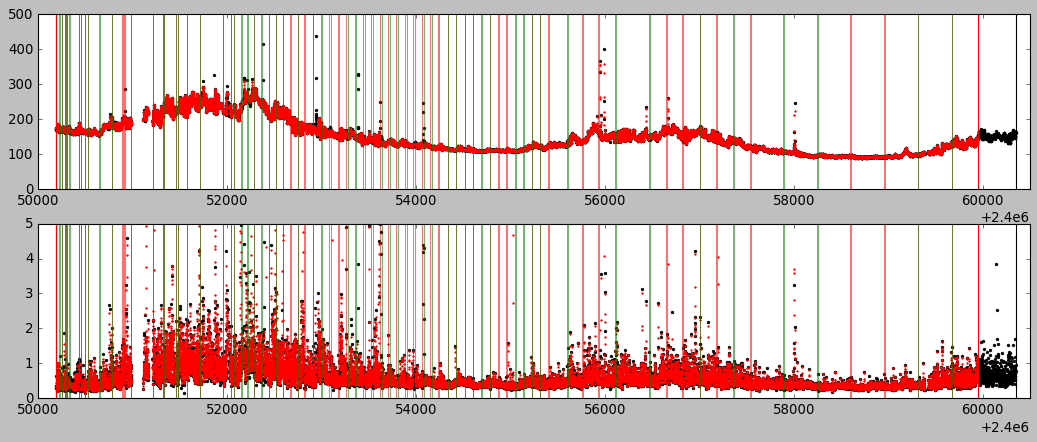

In [16]:
fSEM_interp_304 = np.interp(t304, tSEM, fSEM)
uSEM_interp_304 = np.interp(t304, tSEM, uSEM)

fig, axes = plt.subplots(2,1,figsize=(16,6))
axes[0].plot(tSEM, fSEM, 'k.',ms=5)
axes[0].plot(t304, fSEM_interp_304, 'r.',ms=3)
axes[0].set_ylim(0,500)

axes[1].plot(tSEM, uSEM, 'k.',ms=5)
axes[1].plot(t304, uSEM_interp_304, 'r.',ms=3)
axes[1].set_ylim(0,5)

for ax in axes:
    ax.set_xlim(2450000,2460500)
    ax.axvline(tSEM[0], color='k')
    ax.axvline(tSEM[-1], color='k')

    ax.axvline(t304[0], color='r')
    ax.axvline(t304[-1], color='r')
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)

plt.show()

# define ratio

In [24]:
def normalizedFluxRatio(f1, f2, u1, u2):
    """
    assume f1, f2 are defined on the same array of times and therefore have the same length
    """

    med_f1 = np.median(f1[~np.isnan(f1)])
    med_f2 = np.median(f2[~np.isnan(f2)])

    ratio = (f1/med_f1)/(f2/med_f2)

    unc_med_f1 = np.sqrt((np.pi/2) * np.sum(u1[~np.isnan(u1)]**2/len(u1[~np.isnan(u1)])))
    unc_med_f2 = np.sqrt((np.pi/2) * np.sum(u2[~np.isnan(u2)]**2/len(u2[~np.isnan(u2)])))

    unc_ratio_sq = ((med_f2/(f2 * med_f1))**2 * u1**2) + (((f1*med_f2)/med_f1)**2 * (1/f2**2)**2 * u2**2) + (((f1*med_f2)/f2)**2 * (1/med_f1**2)**2 * unc_med_f1**2) + ((f1/(f2 * med_f1))**2 * unc_med_f2**2)
    unc_ratio = np.sqrt(unc_ratio_sq)

    return ratio, unc_ratio

In [25]:
ratio, unc_ratio = normalizedFluxRatio(f1=f304, f2=fSEM_interp_304, u1=u304, u2=uSEM_interp_304)

In [26]:
# fit two exponentials: one between these two bakeouts (this, June 3, 2016, is the time at which bakeout frequency goes from
# ~every 6 months to ~every year)
fit1Mask = (t304 >= 2455938.417) & (t304 < 2457542.583333)
# and one for the end
fit2Mask = (t304 >= 2457542.583333)

# we're fitting a line to ln(ratio) vs. t
# so need to transform coordinates and uncertainties
t1_to_fit = t304[fit1Mask] - t304[fit1Mask][0]
lnratio1_to_fit = np.log(ratio[fit1Mask])
lnratio1_to_fit_err = (unc_ratio/ratio)[fit1Mask]

noNans1 = ~np.isnan(t1_to_fit) & ~np.isnan(lnratio1_to_fit) & ~np.isnan(lnratio1_to_fit_err)

#fit the line
B1, B1var = least_squares_line(X=t1_to_fit[noNans1],Y=lnratio1_to_fit[noNans1],Yerr=lnratio1_to_fit_err[noNans1])
print(B1)
#print(np.sqrt(B1var))

# transform coordinates and uncertainties for the second exponential
t2_to_fit = t304[fit2Mask] - t304[fit2Mask][0]
lnratio2_to_fit = np.log(ratio[fit2Mask])
lnratio2_to_fit_err = (unc_ratio/ratio)[fit2Mask]

noNans2 = ~np.isnan(t2_to_fit) & ~np.isnan(lnratio2_to_fit) & ~np.isnan(lnratio2_to_fit_err)

B2, B2var = least_squares_line(X=t2_to_fit[noNans2],Y=lnratio2_to_fit[noNans2],Yerr=lnratio2_to_fit_err[noNans2])
print(B2)
#print(np.sqrt(B2var))

[-0.0005932   0.34842489]
[-1.05590341e-04 -5.76467822e-01]


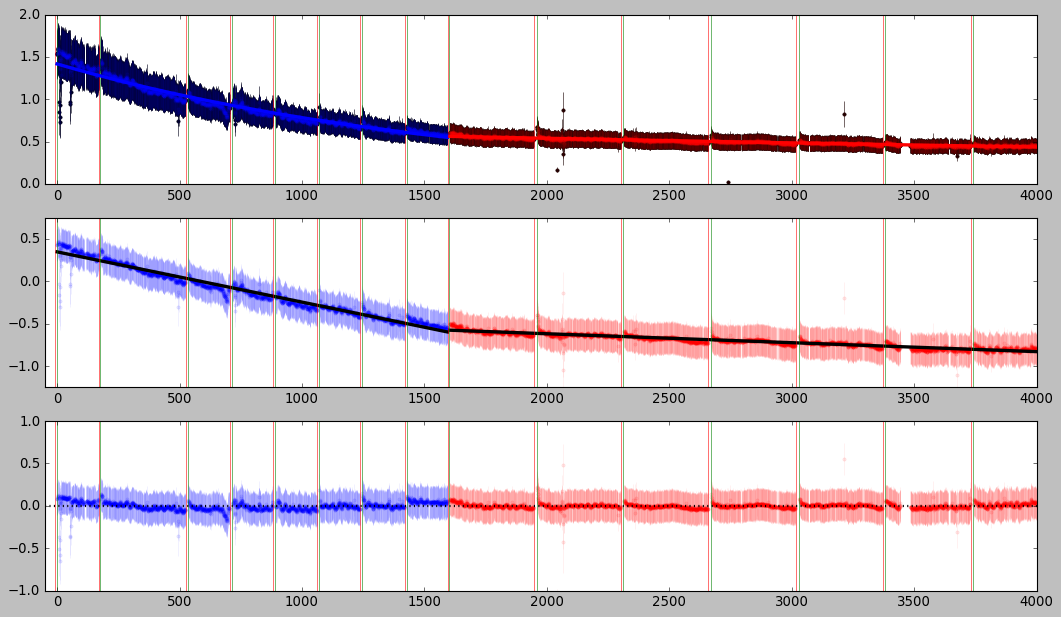

In [27]:
fig, axes = plt.subplots(3,1,figsize=(16,9))
axes[0].errorbar(t304[fit1Mask | fit2Mask] - t304[fit1Mask][0], ratio[fit1Mask | fit2Mask],yerr=unc_ratio[fit1Mask | fit2Mask],marker='.',color='k',elinewidth=0.5,capsize=0,linestyle='None',zorder=1)
axes[0].errorbar(t1_to_fit, ratio[fit1Mask],yerr=unc_ratio[fit1Mask],marker='.',color='b',elinewidth=0.5,capsize=0,linestyle='None',zorder=2,alpha=0.1)
axes[0].errorbar(t2_to_fit + t304[fit2Mask][0] - t304[fit1Mask][0], ratio[fit2Mask],yerr=unc_ratio[fit2Mask],marker='.',color='r',elinewidth=0.5,capsize=0,linestyle='None',zorder=2,alpha=0.1)

axes[0].plot(t1_to_fit, np.exp(B1[0]*t1_to_fit + B1[1]),'b-',lw=3,zorder=3)
axes[0].plot(t2_to_fit + t304[fit2Mask][0] - t304[fit1Mask][0], np.exp(B2[0]*t2_to_fit + B2[1]),'r-',lw=3,zorder=3)

axes[1].errorbar(t1_to_fit, lnratio1_to_fit,yerr=lnratio1_to_fit_err,marker='.',color='b',elinewidth=0.5,capsize=0,linestyle='None',zorder=1,alpha=0.1)
axes[1].plot(t1_to_fit, B1[0]*t1_to_fit + B1[1], 'k-',lw=3,zorder=2)
axes[1].errorbar(t2_to_fit + t304[fit2Mask][0] - t304[fit1Mask][0], lnratio2_to_fit,yerr=lnratio2_to_fit_err,marker='.',color='r',elinewidth=0.5,capsize=0,linestyle='None',zorder=1,alpha=0.1)
axes[1].plot(t2_to_fit + t304[fit2Mask][0] - t304[fit1Mask][0], B2[0]*t2_to_fit + B2[1], 'k-',lw=3,zorder=2)
axes[1].set_ylim(-1.25,0.75)

axes[2].errorbar(t1_to_fit, lnratio1_to_fit - (B1[0]*t1_to_fit + B1[1]), yerr=lnratio1_to_fit_err,marker='.',color='b',elinewidth=0.5,capsize=0,linestyle='None',zorder=1,alpha=0.1)
axes[2].errorbar(t2_to_fit + t304[fit2Mask][0] - t304[fit1Mask][0], lnratio2_to_fit - (B2[0]*t2_to_fit + B2[1]),yerr=lnratio2_to_fit_err, marker='.',color='r',elinewidth=0.5,capsize=0,linestyle='None',zorder=1,alpha=0.1)
axes[2].axhline(0,color='k',ls=':',zorder=3,lw=2)
axes[2].set_ylim(-1,1)


for ax in axes:
    ax.set_xlim(-50,4000)
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate- t304[fit1Mask][0],color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate- t304[fit1Mask][0],color='g',linestyle='-',lw=0.5)

plt.show()

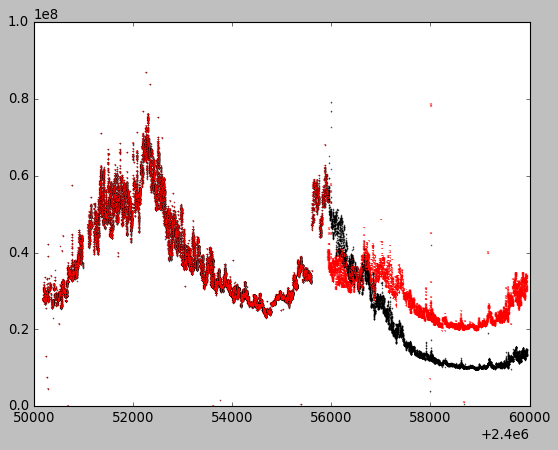

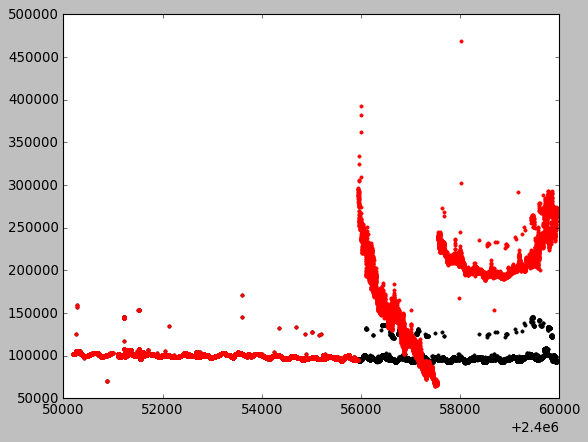

In [28]:
# new arrays to work with
f304_expCorrected = copy.deepcopy(f304)
u304_expCorrected = copy.deepcopy(u304)

# fit parameters, re-notated
A1 = np.exp(B1[1])
# note that sigma_A = dA/dB1 * sigma_B1 = exp(B1) * sigma_B1
sigma_A1 = np.exp(B1[1]) * np.sqrt(B1var[1])
k1 = B1[0]
sigma_k1 = np.sqrt(B1var[0])

A2 = np.exp(B2[1])
sigma_A2 = np.exp(B2[1]) * np.sqrt(B2var[1])
k2 = B2[0]
sigma_k2 = np.sqrt(B2var[0])

# f304,corr = f304/(A*exp(-kt)) = f304 * (1/A) * exp(kt), where A = exp(B[1]) and k = -B[0]
f304_expCorrected[fit1Mask] = f304[fit1Mask]/(A1* np.exp(k1*t1_to_fit))
f304_expCorrected[fit2Mask] = f304[fit2Mask]/(A2* np.exp(k2*t2_to_fit))

# propagate uncertainties analytically
u304_expCorrected[fit1Mask] = np.sqrt( ( (np.exp(k1*t1_to_fit)/A1) * u304[fit1Mask] )**2 + ( ((f304[fit1Mask] * np.exp(k1*t1_to_fit))/A1**2) * sigma_A1 )**2 + ( ((f304[fit1Mask] * np.exp(k1*t1_to_fit) * t1_to_fit)/A1) * sigma_k1 )**2 )
u304_expCorrected[fit2Mask] = np.sqrt( ( (np.exp(k2*t2_to_fit)/A2) * u304[fit2Mask] )**2 + ( ((f304[fit2Mask] * np.exp(k2*t2_to_fit))/A2**2) * sigma_A2 )**2 + ( ((f304[fit2Mask] * np.exp(k2*t2_to_fit) * t2_to_fit)/A2) * sigma_k2 )**2 )

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(t304, f304, u304, color='k',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.errorbar(t304, f304_expCorrected, u304_expCorrected, color='r',marker='.',markersize=1,linestyle='None',elinewidth=2,capsize=0,alpha=0.5)
ax.set_ylim(0.,1e8)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(t304, u304, 'k.')
ax.plot(t304, u304_expCorrected, 'r.')
plt.show()


# redefine ratio

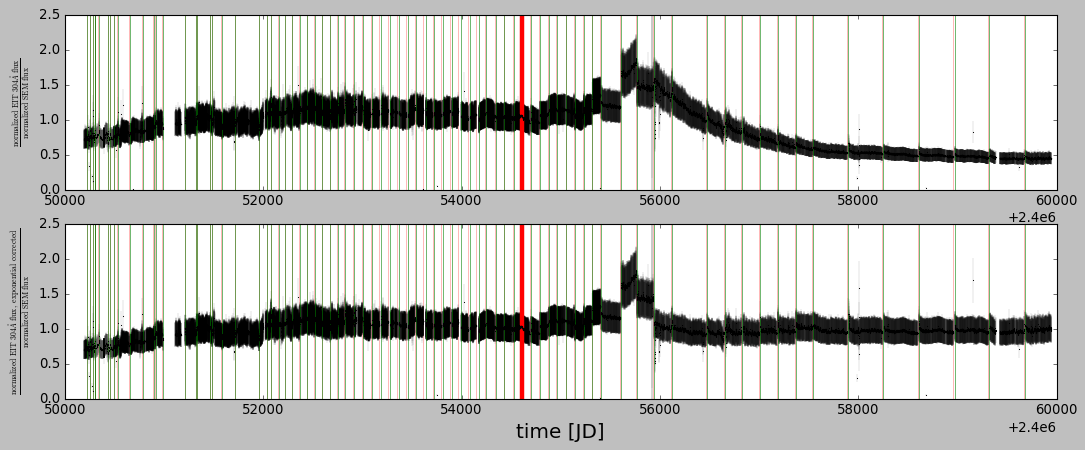

In [29]:
ratio_expCorrected, unc_ratio_expCorrected = normalizedFluxRatio(f1=f304_expCorrected, f2=fSEM_interp_304, u1=u304_expCorrected, u2=uSEM_interp_304)

fig, axes = plt.subplots(2,1,figsize=(16,6))

axes[0].errorbar(t304, ratio, yerr=unc_ratio, color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=1)
axes[1].errorbar(t304, ratio_expCorrected, yerr=unc_ratio_expCorrected, color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=1)

for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']
    for ax in axes:
        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5,zorder=1,alpha=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5,zorder=2,alpha=1)


axes[0].set_ylabel(r"$\frac{\mathrm{normalized\ EIT}\ 304\AA\ \mathrm{flux}}{\mathrm{normalized\ SEM\ flux}}$",fontsize=10)
axes[1].set_ylabel(r"$\frac{\mathrm{normalized\ EIT}\ 304\AA\ \mathrm{flux,\ exponential\ corrected}}{\mathrm{normalized\ SEM\ flux}}$",fontsize=10)
axes[1].set_xlabel(r"time [JD]", fontsize=18)
for ax in axes:
    ax.set_ylim(0,2.5)
    ax.axvline(2454609.072650, color='r', lw=4)

plt.show()

# Now, for each inter-bakeout period, fit a linear relationship to the f304/fSEM ratio and divide it out of f304.

In [30]:
def fitBakeoutSegment(t, ratio, unc_ratio, prev_bakeoutEndDate, next_bakeoutStartDate):
    fitMask = (t >= prev_bakeoutEndDate) & (t <= next_bakeoutStartDate)

    t_to_fit = t[fitMask] - t[fitMask][0]
    ratio_to_fit = ratio[fitMask]
    unc_ratio_to_fit = unc_ratio[fitMask]

    noNans = ~np.isnan(t_to_fit) & ~np.isnan(ratio_to_fit) & ~np.isnan(unc_ratio_to_fit) 

    B, Bunc = least_squares_line(X=t_to_fit[noNans],Y=ratio_to_fit[noNans],Yerr=unc_ratio_to_fit[noNans])

    return fitMask, B, Bunc

def correctLinearBakeoutSegment(t, f, u, B, Bunc):
    # fit parameters, re-notated
    m = B[0]
    sigma_m = np.sqrt(Bunc[0])
    b = B[1]
    sigma_b = np.sqrt(Bunc[1])

    #propagate uncertainties analytically
    fcorr = f/(m*t + b)
    ucorr = np.sqrt( ( (1./(m*t +b)) * u )**2 + ( (-f/(m*t + b)**2) * t * sigma_m )**2 + ( (-f/(m*t + b)**2) * sigma_b )**2 ) 

    return fcorr, ucorr

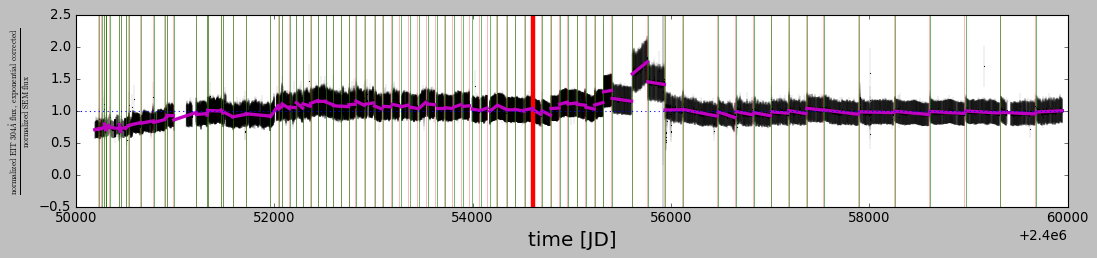

In [31]:
# new arrays to work with
f304_corrected_all = copy.deepcopy(f304_expCorrected)
u304_corrected_all = copy.deepcopy(u304_expCorrected)

f304_corrected_2009onwards = copy.deepcopy(f304_expCorrected)
u304_corrected_2009onwards = copy.deepcopy(u304_expCorrected)


#outlier rejection
unc_ratio_expCorrected[ratio_expCorrected  < 0.5] = np.nan
ratio_expCorrected[ratio_expCorrected < 0.5] = np.nan


# plot linear fits as we go
fig, ax = plt.subplots(1,1,figsize=(16,3))

ax.errorbar(t304, ratio_expCorrected, yerr=unc_ratio_expCorrected, color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=1,zorder=1)

for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']
    ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5,zorder=1,alpha=0.5)
    ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5,zorder=2,alpha=1)

ax.axvline(2454609.072650, color='r', lw=4)

ax.set_ylim(-0.5,2.5)
ax.set_ylabel(r"$\frac{\mathrm{normalized\ EIT}\ 304\AA\ \mathrm{flux,\ exponential\ corrected}}{\mathrm{normalized\ SEM\ flux}}$",fontsize=10)
ax.set_xlabel(r"time [JD]", fontsize=18)


#first segment, before any bakeouts
fitMask, B, Bunc = fitBakeoutSegment(t=t304, ratio=ratio_expCorrected, unc_ratio=unc_ratio_expCorrected, prev_bakeoutEndDate=t304[0], next_bakeoutStartDate=heaterOn[0]['jd'])

ax.plot(t304[fitMask], B[0]*(t304[fitMask] - t304[fitMask][0]) + B[1], 'm-',lw=3,zorder=2)

fcorr, ucorr = correctLinearBakeoutSegment(t304[fitMask]- t304[fitMask][0], f304_expCorrected[fitMask], u304_expCorrected[fitMask], B, Bunc)
f304_corrected_all[fitMask] = fcorr
u304_corrected_all[fitMask] = ucorr

for j in range(80):
    fitMask, B, Bunc = fitBakeoutSegment(t=t304, ratio=ratio_expCorrected, unc_ratio=unc_ratio_expCorrected, prev_bakeoutEndDate=heaterOff[j]['jd'], next_bakeoutStartDate=heaterOn[j+1]['jd'])

    ax.plot(t304[fitMask], B[0]*(t304[fitMask] - t304[fitMask][0]) + B[1], 'm-',lw=3,zorder=2)

    fcorr, ucorr = correctLinearBakeoutSegment(t304[fitMask]- t304[fitMask][0], f304_expCorrected[fitMask], u304_expCorrected[fitMask], B, Bunc)
    f304_corrected_all[fitMask] = fcorr
    u304_corrected_all[fitMask] = ucorr

    # May 22, 2008 (first bakeout with obvious discontinuity)
    if heaterOff[j]['jd'] >= 2454609.072650:
        f304_corrected_2009onwards[fitMask] = fcorr
        u304_corrected_2009onwards[fitMask] = ucorr

#final segment, after all bakeouts
fitMask, B, Bunc = fitBakeoutSegment(t=t304, ratio=ratio_expCorrected, unc_ratio=unc_ratio_expCorrected, prev_bakeoutEndDate=heaterOff[-1]['jd'], next_bakeoutStartDate=t304[-1])

ax.plot(t304[fitMask], B[0]*(t304[fitMask] - t304[fitMask][0]) + B[1], 'm-',lw=3,zorder=2)

fcorr, ucorr = correctLinearBakeoutSegment(t304[fitMask]- t304[fitMask][0], f304_expCorrected[fitMask], u304_expCorrected[fitMask], B, Bunc)
f304_corrected_all[fitMask] = fcorr
u304_corrected_all[fitMask] = ucorr
f304_corrected_2009onwards[fitMask] = fcorr
u304_corrected_2009onwards[fitMask] = ucorr

ax.axhline(1,linestyle=':')
#ax.set_xlim(2454000,2456000)
plt.show()

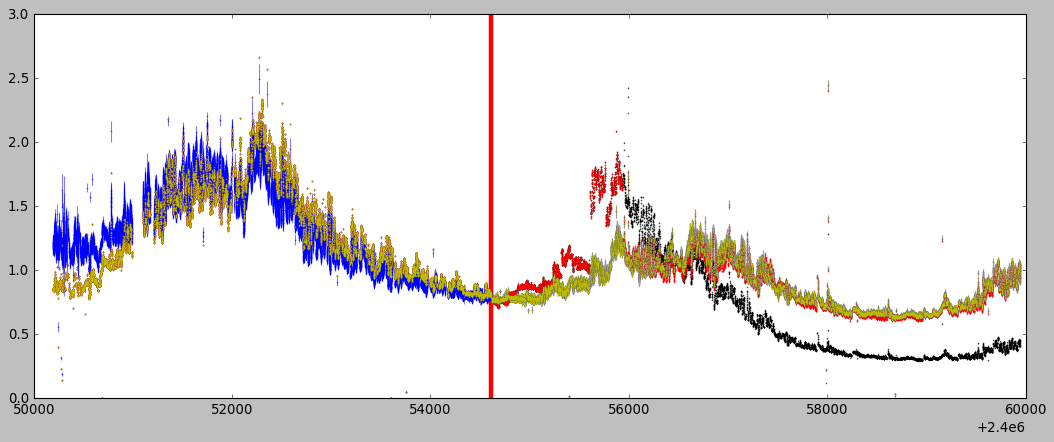

In [32]:
norm = np.median(f304[~np.isnan(f304)])

fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(t304, f304/norm, u304/norm, color='k',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.errorbar(t304, f304_expCorrected/norm, u304_expCorrected/norm, color='r',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.errorbar(t304, f304_corrected_all/norm, u304_corrected_all/norm, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.errorbar(t304, f304_corrected_2009onwards/norm, u304_corrected_2009onwards/norm, color='y',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.axvline(2454609.072650, color='r', lw=4)
#ax.set_ylim(0.,1.e8)
ax.set_ylim(0.,3)
plt.show()

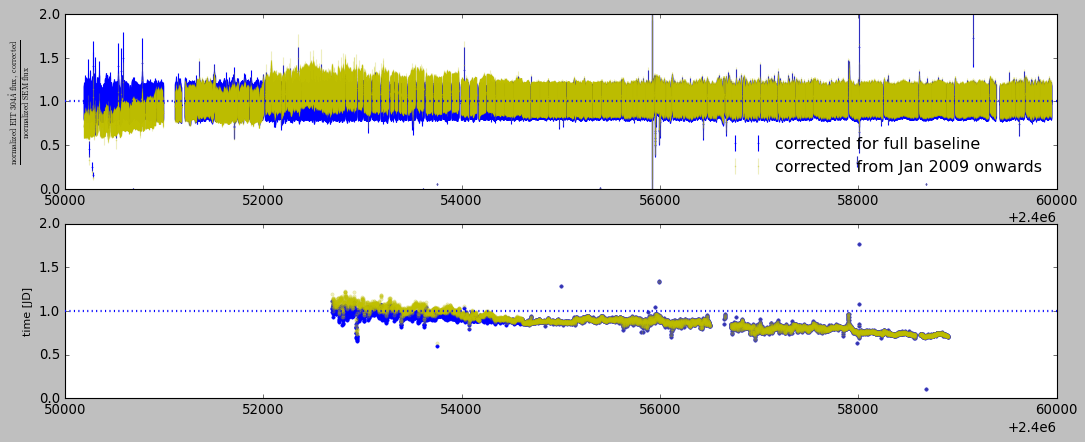

In [39]:
# Plot ratio of corrected 304 to SEM and VIRGO.

fig, axes = plt.subplots(2,1,figsize=(16,6))

ratio_corrected_all, unc_ratio_corrected_all = normalizedFluxRatio(f1=f304_corrected_all, f2=fSEM_interp_304, u1=u304_corrected_all, u2=uSEM_interp_304)
ratio_corrected_2009onwards, unc_ratio_corrected_2009onwards = normalizedFluxRatio(f1=f304_corrected_2009onwards, f2=fSEM_interp_304, u1=u304_corrected_2009onwards, u2=uSEM_interp_304)

axes[0].errorbar(t304, ratio_corrected_all, unc_ratio_corrected_all, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,zorder=1,label='corrected for full baseline')
axes[0].errorbar(t304, ratio_corrected_2009onwards, unc_ratio_corrected_2009onwards, color='y',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,zorder=2,alpha=0.25,label='corrected from Jan 2009 onwards')
axes[0].set_ylim(0.,3)

f304_corrected_all_interp_SORCE = np.interp(tSORCE, t304, f304_corrected_all)
f304_corrected_2009onwards_interp_SORCE = np.interp(tSORCE, t304, f304_corrected_2009onwards)

med_sorce = np.median(fSORCE[~np.isnan(fSORCE)])

sorce_ratio_corrected_all = (f304_corrected_all_interp_SORCE/norm)/(fSORCE/med_sorce)
sorce_ratio_corrected_2009onwards = (f304_corrected_2009onwards_interp_SORCE/norm)/(fSORCE/med_sorce)

axes[1].plot(tSORCE, sorce_ratio_corrected_all, 'b.',zorder=1)
axes[1].plot(tSORCE, sorce_ratio_corrected_2009onwards, 'y.',alpha=0.25,zorder=2)

for ax in axes:
    ax.set_ylim(0.,2.,)
    ax.axhline(1, linestyle=":",lw=2,zorder=3)
    ax.set_xlim(2450000,2460000)

axes[0].set_ylabel(r"$\frac{\mathrm{normalized\ EIT}\ 304\AA\ \mathrm{flux,\ corrected}}{\mathrm{normalized\ SEM\ flux}}$",fontsize=10)
axes[1].set_ylabel(r"$\frac{\mathrm{normalized\ EIT}\ 304\AA\ \mathrm{flux,\ corrected}}{\mathrm{normalized\ SORCE\ flux}}$",fontsize=10)
axes[1].set_ylabel("time [JD]")
axes[0].legend(loc='lower right',frameon=False)
plt.show()

# Now, fit linear relationships between the four EIT bands.

In [150]:
def interpolate_two_EIT_ts(tEIT_1, tEIT_2):
    overlap_t, tEIT_1_ind, tEIT_2_ind = np.intersect1d(np.round(tEIT_1,0), np.round(tEIT_2,0), return_indices=True)
    return overlap_t, tEIT_1_ind, tEIT_2_ind

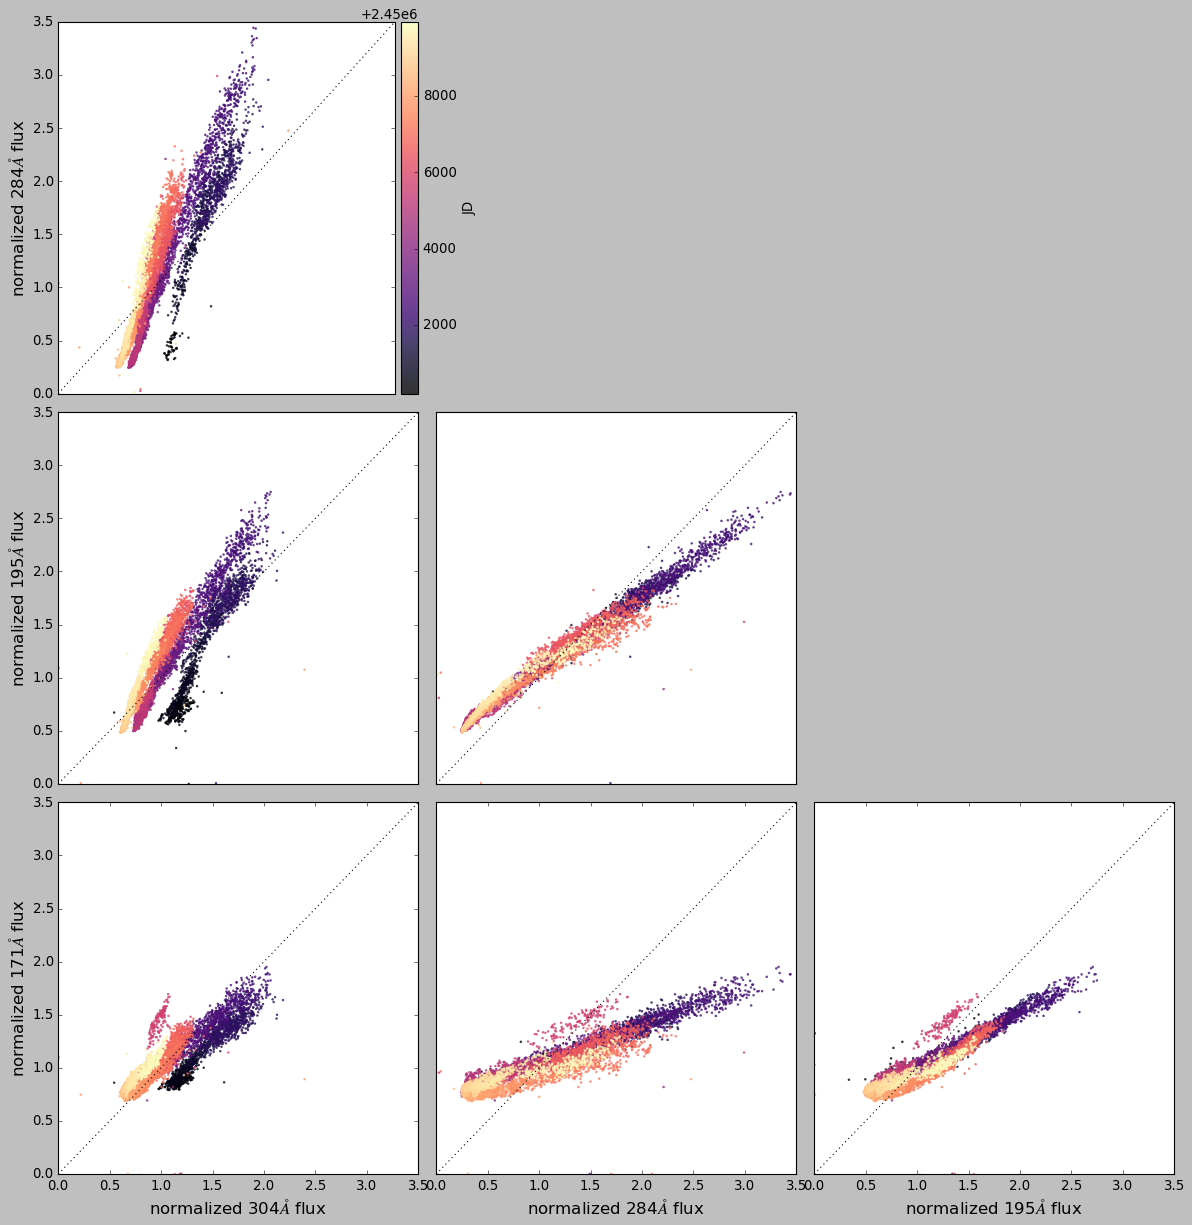

In [153]:
#fArrs_to_plot = [f304_expCorrected, f284, f195, f171]
#uArrs_to_plot = [u304_expCorrected, u284, u195, u171]
fArrs_to_plot = [f304_corrected_all, f284, f195, f171]
uArrs_to_plot = [u304_corrected_all, u284, u195, u171]
tArrs_to_plot = [t304, t284, t195, t171]

fig, axes = plt.subplots(3,3,figsize=(18,18))

for i in range(1,4):

    overlap_t, tEIT_i_ind, t304_ind = interpolate_two_EIT_ts(tArrs_to_plot[i], tArrs_to_plot[0])
    
    c_s = axes[i-1,0].scatter(fArrs_to_plot[0][t304_ind]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), c=tArrs_to_plot[0][t304_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8)
   
    axes[i-1,0].set_xlim(0,3.5)
    axes[i-1,0].set_ylim(0,3.5)

    if i==1:
        divider = make_axes_locatable(axes[0,0])
        cax = divider.append_axes("right", size="5%", pad="2%")
        fig.add_axes(cax)
        cbar = fig.colorbar(c_s, cax=cax,label="JD")
        #cbar.set_ticks([])


axes[2,0].set_xlabel(r"normalized 304$\AA$ flux",fontsize=15)
axes[0,0].set_ylabel(r"normalized 284$\AA$ flux",fontsize=15)
axes[1,0].set_ylabel(r"normalized 195$\AA$ flux",fontsize=15)
axes[2,0].set_ylabel(r"normalized 171$\AA$ flux",fontsize=15)


for i in range(2,4):
    overlap_t, tEIT_i_ind, t284_ind = interpolate_two_EIT_ts(tArrs_to_plot[i], tArrs_to_plot[1])
    
    axes[i-1,1].scatter(fArrs_to_plot[1][t284_ind]/np.median(fArrs_to_plot[1][~np.isnan(fArrs_to_plot[1])]), fArrs_to_plot[i][tEIT_i_ind]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), c=tArrs_to_plot[1][t284_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8)

    axes[i-1,1].set_xlim(0,3.5)
    axes[i-1,1].set_ylim(0,3.5)

axes[2,1].set_xlabel(r"normalized 284$\AA$ flux",fontsize=15)

#axes[1,1].set_ylabel("normalized 195 flux")
#axes[2,1].set_ylabel("normalized 171 flux")


for i in range(3,4):
    overlap_t, tEIT_i_ind, t195_ind = interpolate_two_EIT_ts(tArrs_to_plot[i], tArrs_to_plot[2])
    
    axes[i-1,2].scatter(fArrs_to_plot[2][t195_ind]/np.median(fArrs_to_plot[2][~np.isnan(fArrs_to_plot[2])]), fArrs_to_plot[i][tEIT_i_ind]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), c=tArrs_to_plot[2][t195_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8)

    axes[i-1,2].set_xlim(0,3.5)
    axes[i-1,2].set_ylim(0,3.5)

axes[2,2].set_xlabel(r"normalized 195$\AA$ flux",fontsize=15)
#axes[2,2].set_ylabel("normalized 171 flux")


for ax in [axes[0,1],axes[0,2],axes[1,2]]:
    ax.axis("off")

for ax in [axes[0,0],axes[1,0],axes[1,1],axes[2,0],axes[2,1],axes[2,2]]:
    ax.plot(np.arange(5),np.arange(5),color='k',ls=':')

axes[0,0].set_xticks([])
axes[1,0].set_xticks([])
axes[1,1].set_xticks([])

axes[1,1].set_yticks([])
axes[2,1].set_yticks([])
axes[2,2].set_yticks([])
#plt.show()
plt.subplots_adjust(hspace=0.05,wspace=0.05)

#plt.savefig("./ratio_EITbands_to_eachother_expCorrected.pdf",bbox_inches="tight")
plt.savefig("./ratio_EITbands_to_eachother_corrected.pdf",bbox_inches="tight")

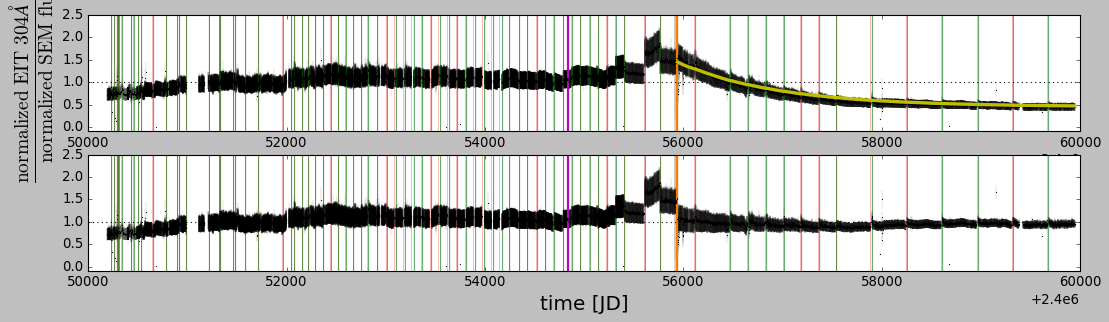

In [18]:

fig, axes = plt.subplots(2,1,figsize=(16,4))
axes[0].errorbar(t304, ratio, yerr=unc_ratio, color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=1)
axes[0].set_ylim(-0.1,2.5)

for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']
    for ax in axes:
        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5,zorder=1,alpha=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5,zorder=2,alpha=1)
        ax.axvline(bakeoutEndDate+7, color='k',linestyle='-',lw=0.1)

axes[0].set_ylabel(r"$\frac{\mathrm{normalized\ EIT}\ 304\AA\ \mathrm{flux}}{\mathrm{normalized\ SEM\ flux}}$",fontsize=25)
axes[1].set_xlabel(r"time [JD]", fontsize=18)
#ax.axvline(2455932.375,color='y',lw=3)

xs = np.linspace(0.,4.,7000)
ys = np.exp(-xs)
#ax.plot(1000*xs+2456000, ys+0.45,lw=3,c='y',zorder=10)


axes[0].plot(t304[t304 >= 2455938], ys[:6907]+0.45, lw=3,c='y',zorder=10)

testRemoveExp = np.ones_like(t304)
testRemoveExp[t304 >= 2455938] = ys[:6907] + 0.45

axes[1].errorbar(t304, ratio/testRemoveExp, yerr=unc_ratio, color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=1)
axes[1].set_ylim(-0.1,2.5)

for ax in axes:
    #ax.set_xlim(2457350,2457450)
    #ax.axvline(2452941,color='m',lw=1)
    #ax.axvline(2452177,color='m',lw=1)
    #ax.axvline(2452237,color='m',lw=1)
    #ax.axvline(2452384,color='m',lw=1)
    ax.axvline(2454833,color='m',lw=2)       #Jan 1, 2009.  Bad bakeout discontinuities obvious after this.
    ax.axvline(2455938.417,color='#f77f00',lw=2) #Jan 11, 2012. Exponential trend obvious after this.


    ax.axhline(1,color='k',linestyle=':')

#plt.show()
plt.savefig("./ratio_EIT304_to_SEM.pdf",bbox_inches="tight")


In [27]:
def correctByRatio(t, f, u, t_ratio, ratio, unc_ratio, plot=True):
    norm = np.median(f[~np.isnan(f)])
    ratio_interp = np.interp(t, t_ratio, ratio)
    unc_ratio_interp = np.interp(t, t_ratio, unc_ratio)

    if plot is True:
        fig, ax = plt.subplots(1,1,figsize=(16,4))
        ax.plot(t, f/norm, 'r.')
        ax.plot(t, (f/ratio_interp)/norm, 'k.')
        #ax.set_xlim(2454000, 2456000)
        ax.set_ylim(0.,5.)
        plt.show()

    u_new_sq = (u**2/ratio_interp**2) + (unc_ratio_interp**2/ratio_interp**4)
    u_new = np.sqrt(u_new_sq)
    
    return norm, f/ratio_interp, u_new

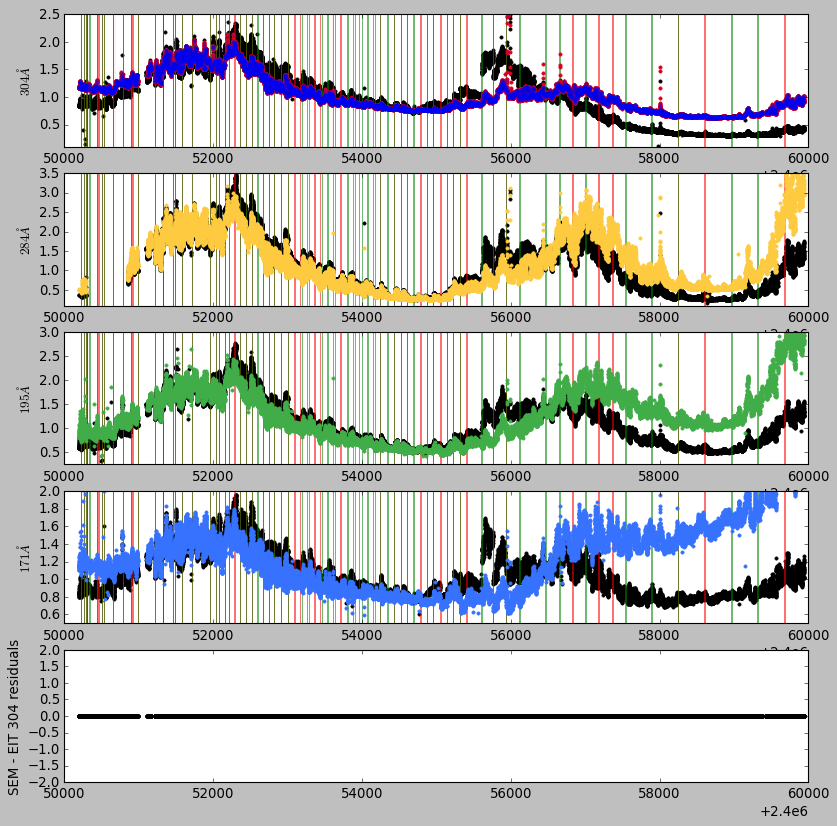

In [29]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
labels =['304','284','195','171']

fig, axes = plt.subplots(5,1,figsize=(12,12))

for i in range(4):
    wmask_ = wmasks[i] & noPinholes & ~withinBakeout & ~nearSnow
    tEIT = ts[wmask_]
    fEIT = fs[wmask_] 
    uEIT = us[wmask_]
    norm, fcorrect, ucorrect = correctByRatio(t=tEIT, f=fEIT, u=uEIT, t_ratio=t304, ratio=ratio, unc_ratio=unc_ratio, plot=False)

    #axes[i].plot(tEIT, fEIT/norm, 'k.')
    #axes[i].plot(tEIT, fcorrect/norm, marker='.', color=cs[i],ls='None')

    axes[i].errorbar(tEIT, fEIT/norm, uEIT/norm, color='k', marker='.',ls='None',elinewidth=0.1,capsize=0,zorder=1)
    axes[i].errorbar(tEIT, fcorrect/norm, ucorrect/norm, color=cs[i], marker='.',ls='None',elinewidth=0.1,capsize=0,zorder=2)
    axes[i].set_ylabel(r"${0}\AA$".format(labels[i]))
    #axes[i].set_xlim(2450000, 2460500)
    #axes[i].set_xlim(2455000, 2457000)
    axes[i].set_ylim(0.,4.)

    if i==0:
        axes[4].plot(t304, fSEM_interp_304/np.median(fSEM_interp_304[~np.isnan(fSEM_interp_304)]) - fcorrect/norm, 'k.')

    for j in range(81):
        bakeoutStartDate = heaterOn[j]['jd']
        bakeoutEndDate = heaterOff[j]['jd']

        axes[i].axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        axes[i].axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)


    #axes[i].plot(tSORCE, fSORCE/np.median(fSORCE[~np.isnan(fSORCE)]), 'c-',zorder=4)

#plot SEM
axes[0].errorbar(t304, fSEM_interp_304/np.median(fSEM_interp_304[~np.isnan(fSEM_interp_304)]), uSEM_interp_304/np.median(fSEM_interp_304[~np.isnan(fSEM_interp_304)]), color='b', marker='.',ls='None',elinewidth=0.1,capsize=0,alpha=0.1,zorder=3)
#axes[4].set_xlim(2455000, 2457000)
axes[4].set_ylim(-2,2)
axes[4].set_ylabel("SEM - EIT 304 residuals")

axes[0].set_ylim(0.1,2.5)
axes[1].set_ylim(0.1,3.5)
axes[2].set_ylim(0.25,3.)
axes[3].set_ylim(0.5,2.)

plt.show()

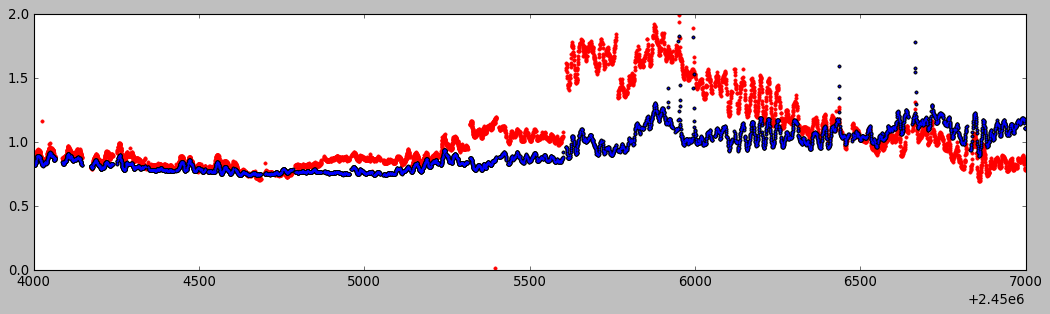

In [30]:
norm = np.median(f304[~np.isnan(f304)])
fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(t304, f304/norm, 'r.')
ax.plot(t304, (f304/ratio)/norm, 'k.')
ax.plot(t304, fSEM_interp_304/np.median(fSEM_interp_304[~np.isnan(fSEM_interp_304)]), 'b.',ms=2)
ax.set_xlim(2454000, 2457000)
#ax.set_ylim(0.,1.e8)
ax.set_ylim(0,2)
plt.show()

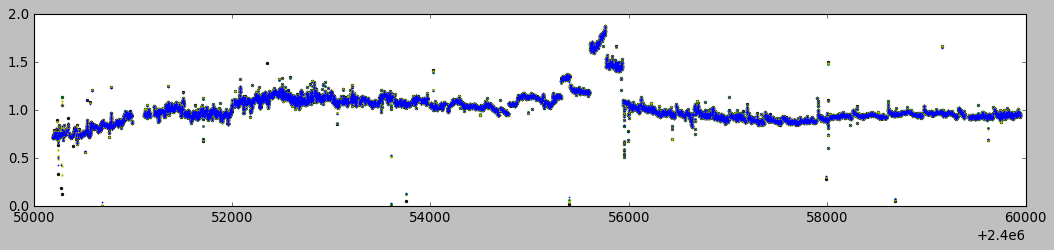

In [31]:
ratio_interp_284 = np.interp(t284, t304, ratio/testRemoveExp)
ratio_interp_195 = np.interp(t195, t304, ratio/testRemoveExp)
ratio_interp_171 = np.interp(t171, t304, ratio/testRemoveExp)
fig, ax = plt.subplots(1,1,figsize=(16,3))
ax.plot(t304, ratio/testRemoveExp, 'k.',ms=5)
ax.plot(t284, ratio_interp_284, 'g.',ms=4)
ax.plot(t195, ratio_interp_195, 'y.',ms=3)
ax.plot(t171, ratio_interp_171, 'b.',ms=2)
ax.set_ylim(0.,2.)
plt.show()

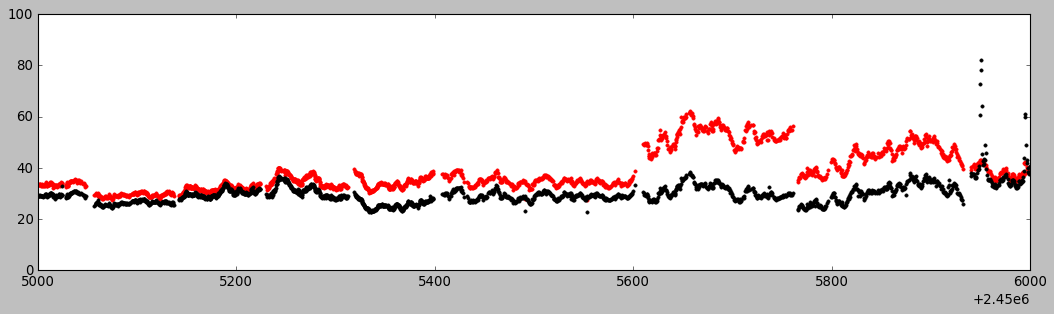

In [32]:
norm = np.median(t171[~np.isnan(t171)])
fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(t171, f171/norm, 'r.')
ax.plot(t171, (f171/ratio_interp_171)/norm, 'k.')
ax.set_xlim(2455000, 2456000)
#ax.set_ylim(0.,1.e8)
ax.set_ylim(0,100)
plt.show()

In [71]:
def least_squares_line(X,Y,Yerr):
    """
    Solve the normal equation B = (X.T*C.inv*X).inv*X.T*C.inv*Y
    Inputs:
    X = matrix of x values
    bOOT = integer best BIC polynomial OOT order
    Y = vector of y values
    Yerr = vector of yerr values
    Outputs:
    B = vector of model parameters that minimizes chi^2
    Bunc = analytic uncertainties on those parameters (see e.g. )
    """
    # least squares params
    Xmat = np.vander(X, 2)
    
    XTX = np.dot(Xmat.T, Xmat/Yerr[:, None]**2)
    
    B = np.linalg.solve(XTX, np.dot(Xmat.T, Y/Yerr**2))


    #uncertainties on least squares params
    N = len(Y)

    prefac = 1./(np.sum(1./Yerr**2)*np.sum(X**2/Yerr**2) - (np.sum(X/Yerr**2)**2))
    intercept_unc = np.sum( ((prefac/Yerr**2)*(np.sum(X**2/Yerr**2) - X*np.sum(X/Yerr**2)))**2 * Yerr**2)
    slope_unc =     np.sum( ((prefac/Yerr**2)*(-np.sum(X/Yerr**2)   + X*np.sum(1/Yerr**2)))**2 * Yerr**2)

    Bvar = np.array((slope_unc, intercept_unc))
    
    return B, Bvar

(20,)
(20,)
(20,)
[  1.07674752 213.27349198]
[ 0.07740678 14.39403311]


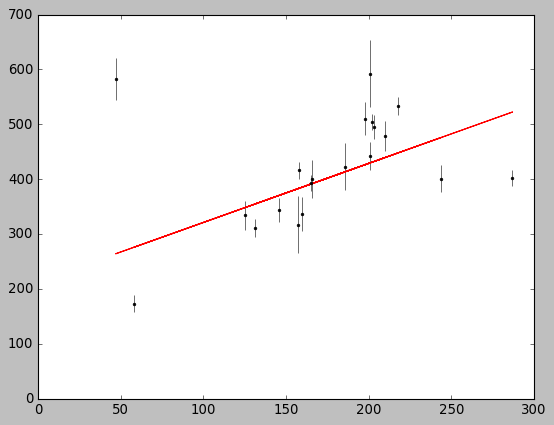

In [74]:
x = np.array((201,244,47,287,203,58,210,202,198,158,165,201,157,131,166,160,186,125,218,146))
y = np.array((592,401,583,402,495,173,479,504,510,416,393,442,317,311,400,337,423,334,533,344))
yerr=np.array((61,25,38,15,21,15,27,14,30,16,14,25,52,16,34,31,42,26,16,22))

#x=x[4:]
#y=y[4:]
#yerr=yerr[4:]

print(np.shape(x))
print(np.shape(y))
print(np.shape(yerr))

b,bunc = least_squares_line(x,y,yerr)
print(b)
#print(bunc)
print(np.sqrt(bunc))


fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(x,y,yerr,color='k',ms=5,marker='.',elinewidth=0.5,capsize=0,ls='None')
ax.plot(x,b[0]*x + b[1],color='r',ls='-',marker='None')
ax.set_xlim(0,300)
ax.set_ylim(0,700)
plt.show()